In [1]:
#librerias que deben estar instaladas. En caso contrario instalar usando pip 

import seaborn as sns
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from fpdf import FPDF

 #en el directorio de ejecucion se creara un directorio /resources/ donde se guardan las imagenes con los graficos que se insertaran en el pdf 
 se genera un fichero "informe_ipc.pdf" con el informe

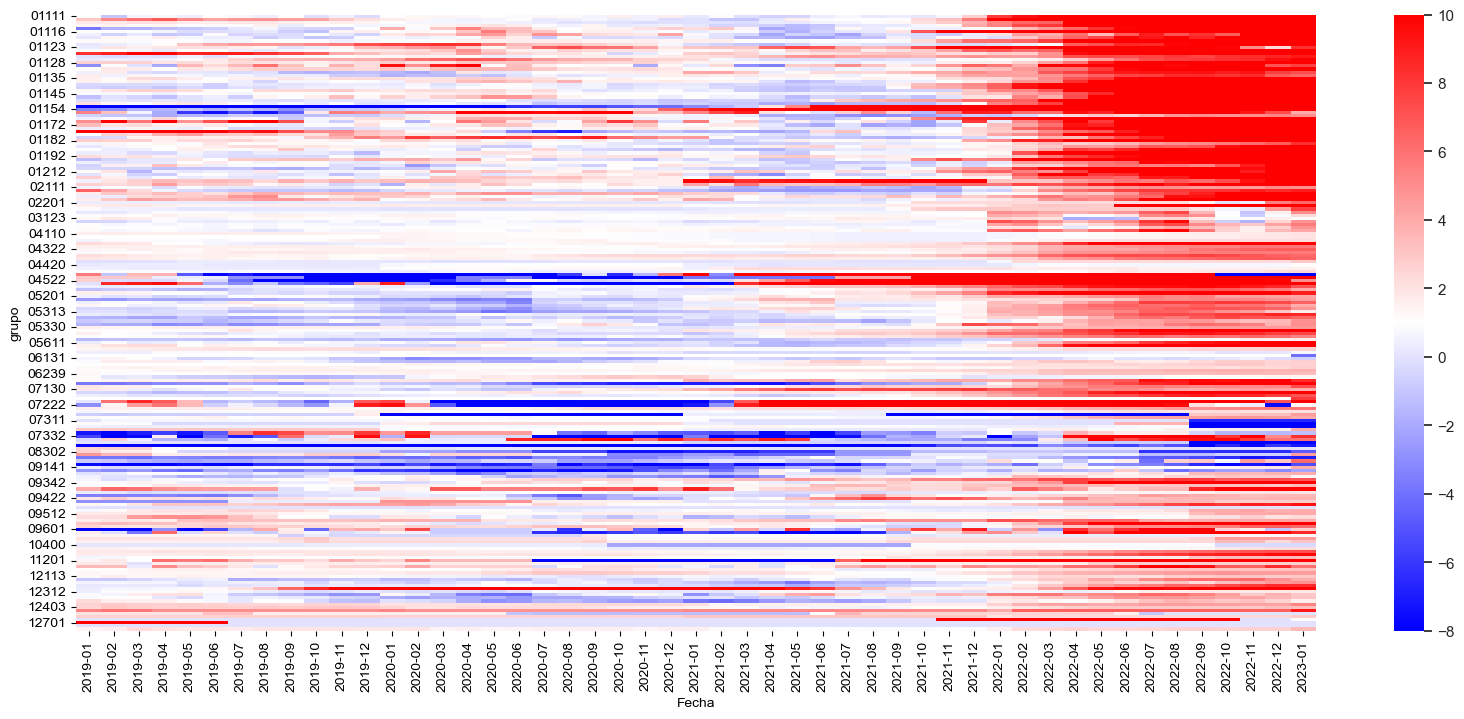

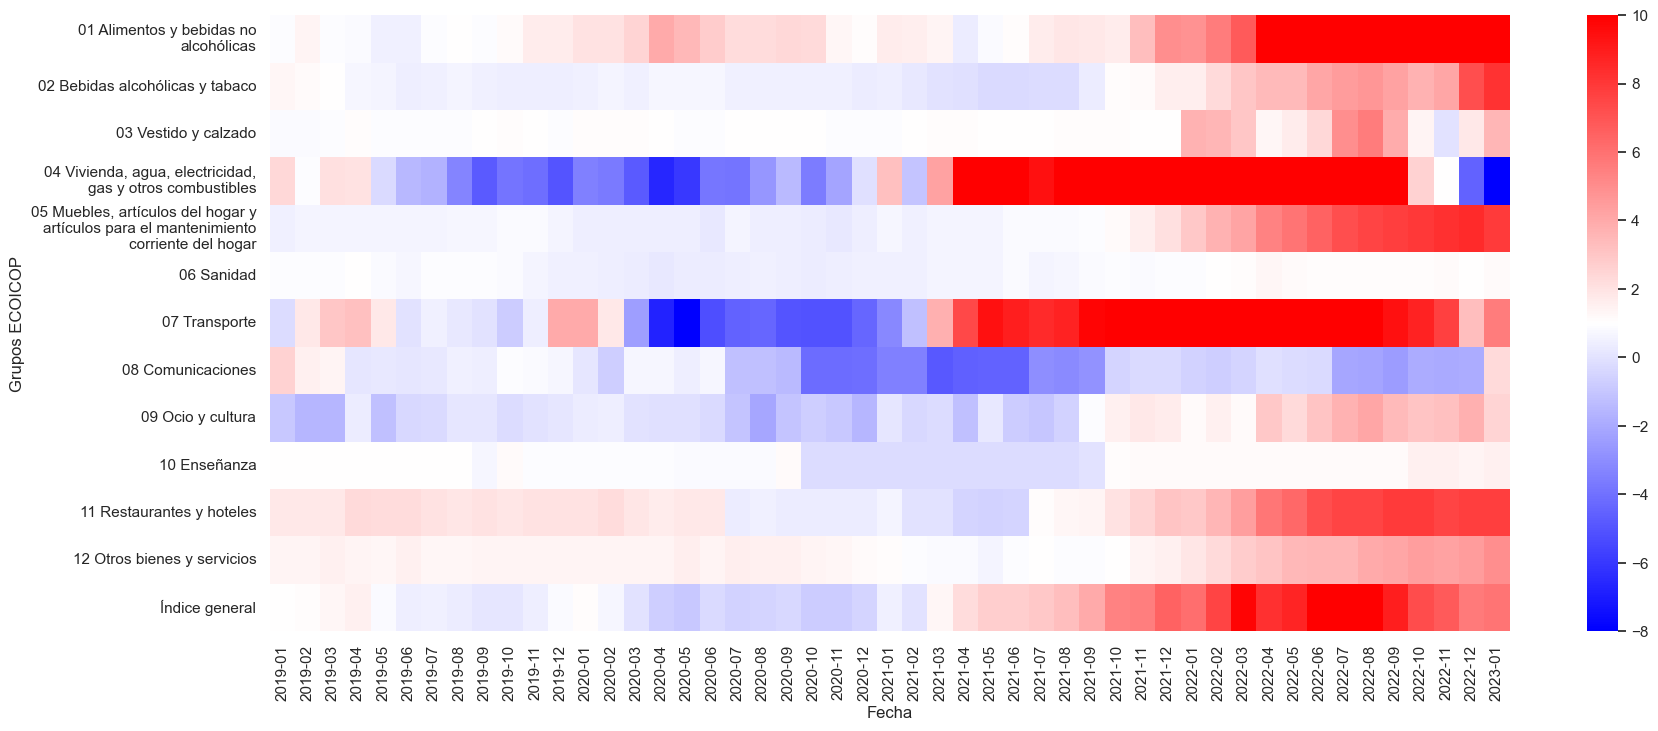

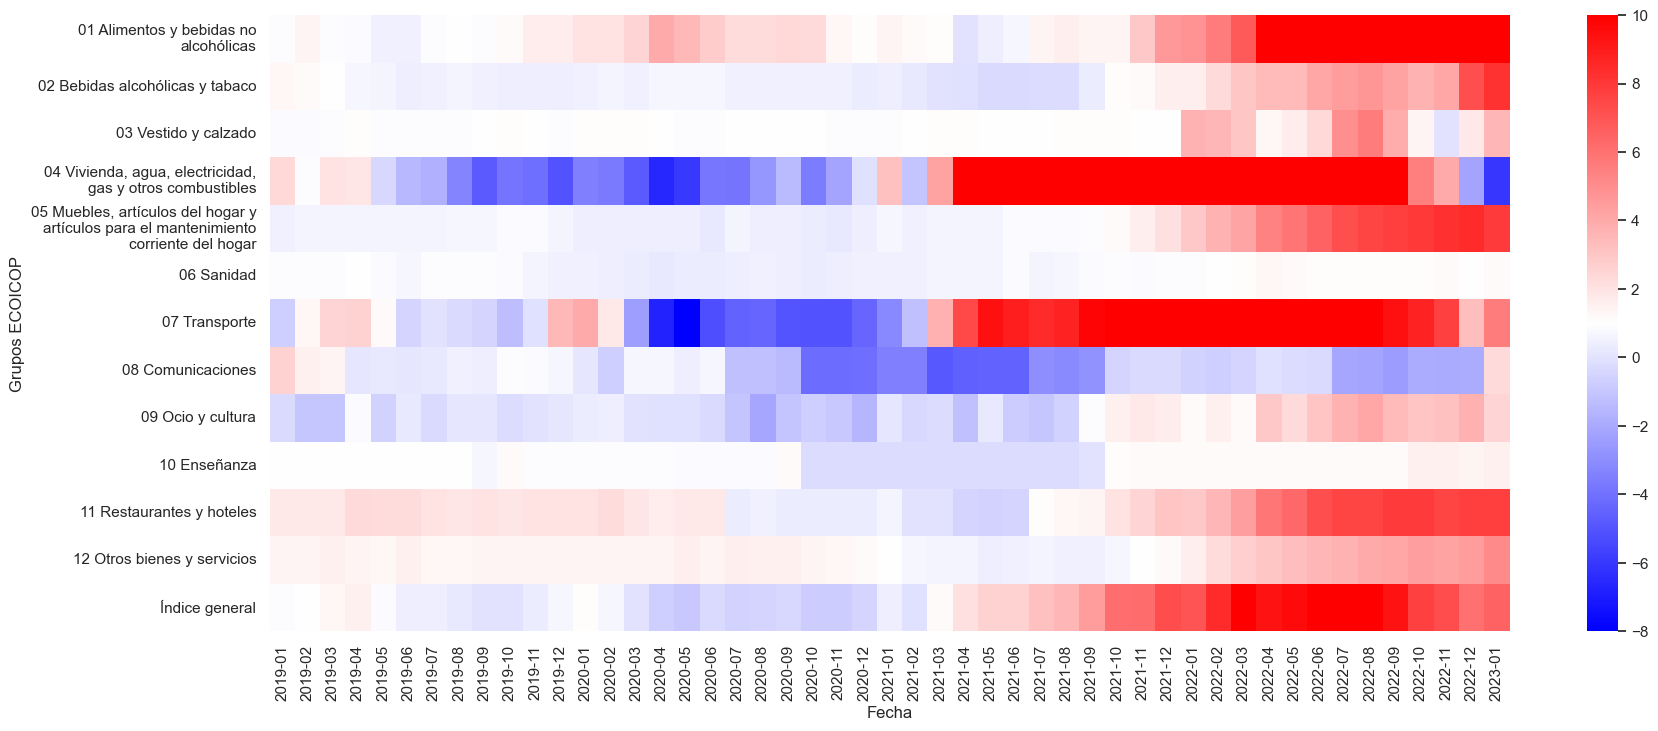

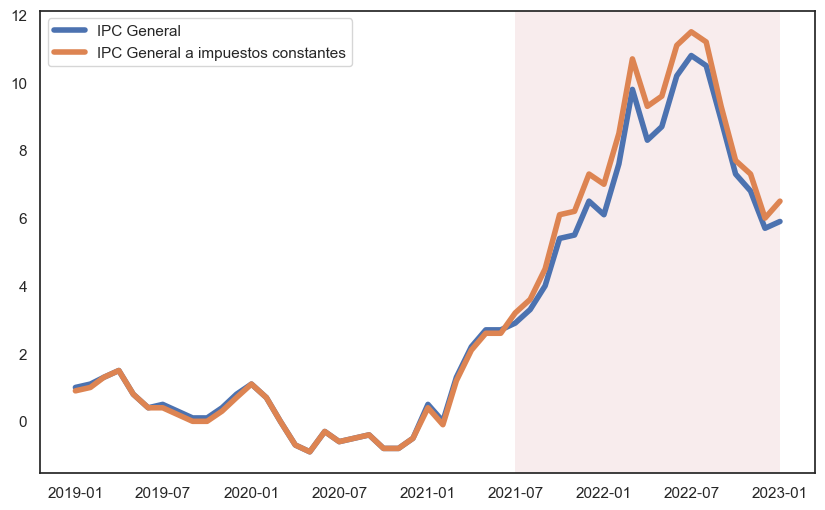

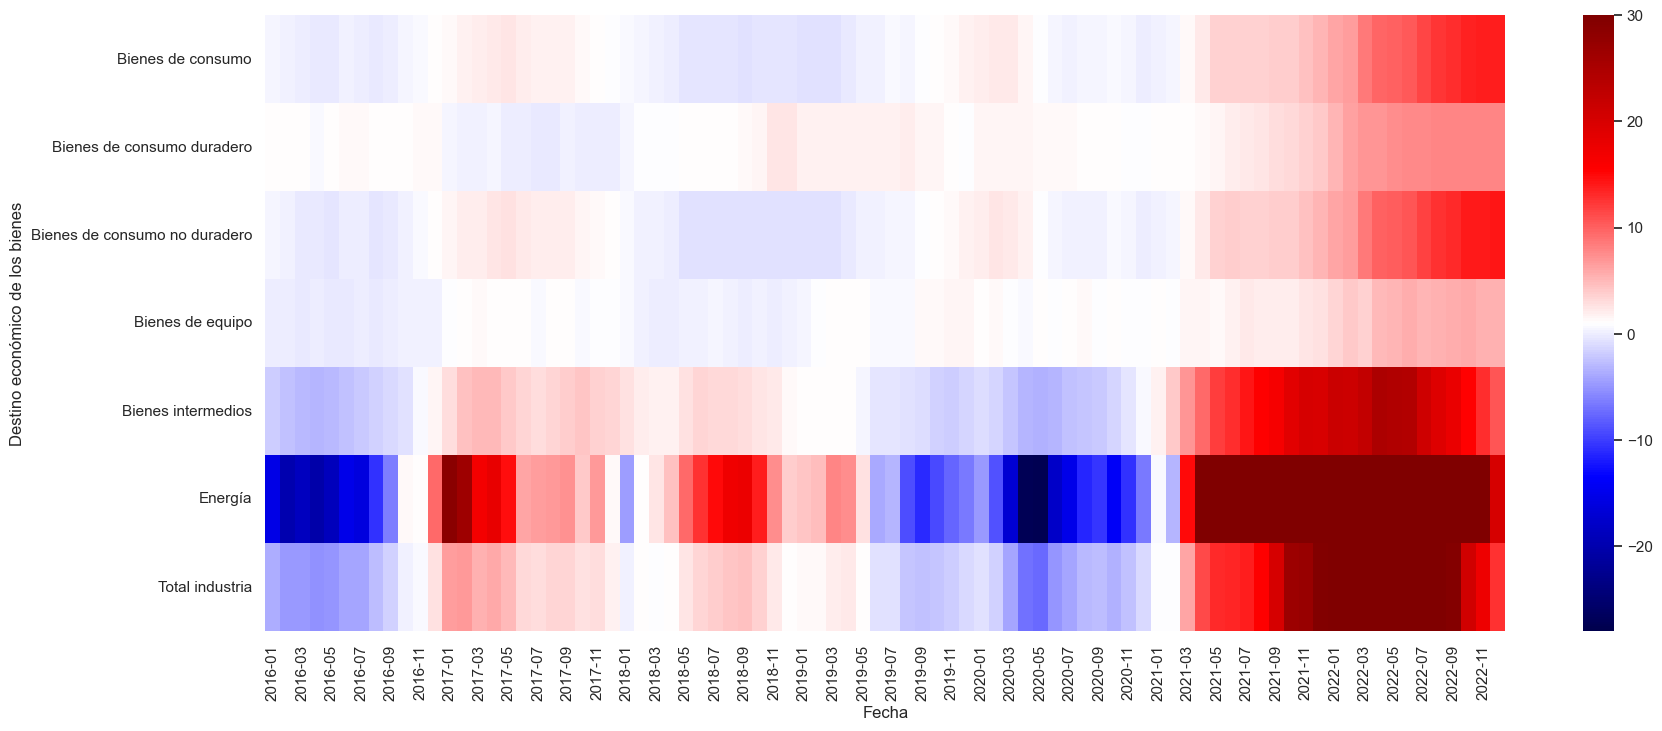

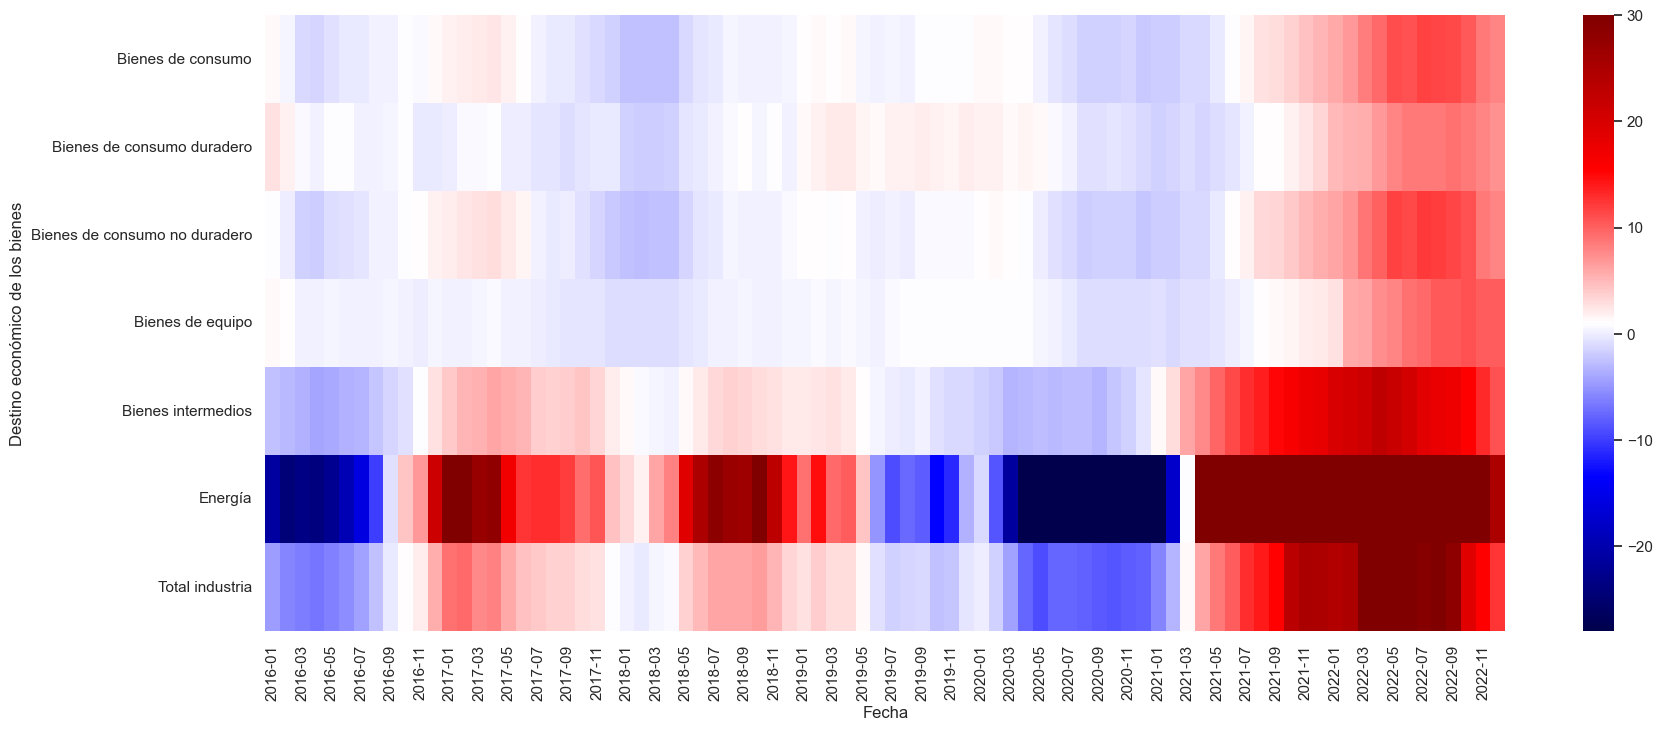

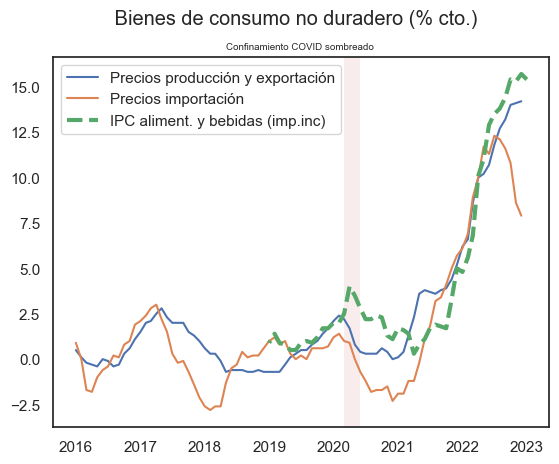

In [2]:
from datetime import datetime
#esto es lo que hay que cambiar cada mes
mes=datetime(2023,1,1)   #para IPC sale a principios de mes
mes2=datetime(2022,11,30) #para ipri sale a fnales de mes
texto="IPC Ene 2023"



url='https://ine.es/jaxiT3/files/t/es/csv_bdsc/50905.csv?nocab=1'
ans=r = requests.get(url, stream=True)
data=pd.read_csv(io.BytesIO(ans.content), delimiter = ";",thousands='.', decimal=',' , low_memory=False)



data=data[data['Tipo de dato']=='Variación anual']
data['grupo']=[i[:5] for i in data['Subclases']]
data['grupo2']=[i[:2] for i in data['Subclases']]
data=data[data['grupo2']!='Ín']
data=data[data['grupo']!='12704']
data['Total']=[str(i).replace(',','.').replace('..','nan') for i in data.Total]
data['Total']=pd.to_numeric(data['Total'],errors='coerce')
data['Periodo']=pd.to_datetime(data['Periodo'],format='%YM%m')
data['Fecha'] = data['Periodo'].dt.to_period('M')
data['year']=data.Periodo.dt.year
data=data[data.year>2018]


pivo=pd.pivot_table(index='grupo',columns='Fecha', values='Total', data=data.dropna())


f,ax=plt.subplots(figsize=(20,8))
plt.rcParams["axes.labelsize"] = 5
sns.set_theme(style="white")
g=sns.heatmap(pivo, cmap='bwr',vmin=-8, vmax=10)
#ax.set_yticklabels([textwrap.fill(e, 35) for e in pivo.index])
plt.savefig('./resources/subclases.png')



#grupos especiales
url1='https://ine.es/jaxiT3/files/t/es/csv_bdsc/50907.csv?nocab=1'

##General y grupos
url2='https://ine.es/jaxiT3/files/t/es/csv_bdsc/50902.csv?nocab=1'
##General y grupos a impuestos constantes
url3='https://ine.es/jaxiT3/files/t/es/csv_bdsc/50908.csv?nocab=1'

lista=['Alimentos sin elaboración','Productos energéticos','Alimentos elaborados',
       'Alimentos elaborados','Bienes industriales sin energía','Servicios']

def gener_datos(url,name):
    ans=r = requests.get(url, stream=True)
    data=pd.read_csv(io.BytesIO(ans.content), delimiter = ";",thousands='.', decimal=',' , low_memory=False)
    data=data[data['Tipo de dato']=='Variación anual']
    data['Periodo']=pd.to_datetime(data['Periodo'],format='%YM%m')
    #data=data[data['Grupos ECOICOP'].isin(lista)]
    data['Total']=[str(i).replace(',','.').replace('..','nan') for i in data.Total]

    data['Total']=pd.to_numeric(data['Total'],errors='coerce')
    data['Fecha'] = data['Periodo'].dt.to_period('M')
    data['year']=data.Periodo.dt.year
    data=data[data.year>2018]
    import textwrap
    pivo=pd.pivot_table(index='Grupos ECOICOP',columns='Fecha', values='Total', data=data.dropna())
    f,ax=plt.subplots(figsize=(20,8))
    plt.rcParams["axes.labelsize"] = 5
    sns.set_theme(style="white")
    g=sns.heatmap(pivo, cmap='bwr',vmin=-8, vmax=10)
    ax.set_yticklabels([textwrap.fill(e, 35) for e in pivo.index])
    plt.savefig('./resources/{cosa}.png'.format(cosa=name))
    return(data)

conim=gener_datos(url2,'coicop_con')
sinim=gener_datos(url3,'coicop_sin')


conim.to_excel('conim.xlsx')
sinim.to_excel('sinim.xlsx')



f,ax=plt.subplots(figsize=(10,6))
plt.axvspan(datetime(2021,7,1), datetime(2023,1,1), color='r', alpha=0.1, lw=0)
ax.plot(conim[conim['Grupos ECOICOP']=='Índice general'].set_index('Periodo')['Total'],linewidth=4,label='IPC General')
ax.plot(sinim[sinim['Grupos ECOICOP']=='Índice general'].set_index('Periodo')['Total'],linewidth=4,label='IPC General a impuestos constantes')
plt.legend()
plt.savefig('./resources/imp_noIM.png')

import dataframe_image as dfi

cosa=conim[['Grupos ECOICOP','Periodo','Total']][conim.Periodo==mes]
cosa_f=cosa.style.format({'Periodo':"{:%Y.%m}",'Total':"{:.2f}%"}).hide(axis="index").bar(subset=['Total'], cmap='seismic',vmin=-22,vmax=24)
cosa_f

dfi.export(cosa_f, './resources/cosa_f.png',chrome_path=None)

cosa=sinim[['Grupos ECOICOP','Periodo','Total']][sinim.Periodo==mes]
cosa_f=cosa.style.format({'Periodo':"{:%Y.%m}",'Total':"{:.2f}%"}).hide(axis="index").bar(subset=['Total'], cmap='seismic',vmin=-22,vmax=24)
cosa_f

dfi.export(cosa_f, './resources/cosa_sin.png',chrome_path=None)



url='https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/27097.csv?nocab=1'
url2='https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/27102.csv?nocab=1'  #ipri+exportacion
url3='https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/27107.csv?nocab=1' #importacion

def gener_datos(url,name):
    ans=r = requests.get(url, stream=True)
    data=pd.read_csv(io.BytesIO(ans.content), delimiter = ";",thousands='.', decimal=',' , low_memory=False)
    data=data[data['Índice y tasas']=='Variación anual']
    data.columns=[i.rstrip() for i in data.columns]
    data=data[data['Destino económico de los bienes']!='Total industria sin energía']
    
    data['Periodo']=pd.to_datetime(data['Periodo'],format='%YM%m')
    #data=data[data['Grupos ECOICOP'].isin(lista)]
    data['Total']=[str(i).replace(',','.').replace('..','nan') for i in data.Total]

    data['Total']=pd.to_numeric(data['Total'],errors='coerce')
    data['Fecha'] = data['Periodo'].dt.to_period('M')
    data['year']=data.Periodo.dt.year
    data=data[data.year>2015]
    import textwrap
    pivo=pd.pivot_table(index='Destino económico de los bienes',columns='Fecha', values='Total', data=data.dropna())
    f,ax=plt.subplots(figsize=(20,8))
    plt.rcParams["axes.labelsize"] = 5
    sns.set_theme(style="white")
    g=sns.heatmap(pivo, cmap='seismic',vmin=-28, vmax=30)
    ax.set_yticklabels([textwrap.fill(e, 35) for e in pivo.index])
    plt.savefig('./resources/{cosa}.png'.format(cosa=name))
    return(data)


prodyx=gener_datos(url2,'heatmap_prodx')
pimp=gener_datos(url3,'heatmap_pimp')


cosa=prodyx[['Destino económico de los bienes','Periodo','Total']][prodyx.Periodo>=mes2]
cosa_f=cosa.style.format({'Periodo':"{:%Y.%m}",'Total':"{:.2f}%"}).hide(axis="index").bar(subset=['Total'], cmap='seismic',vmin=-22,vmax=24)
cosa_f
dfi.export(cosa_f, './resources/producx.png',chrome_path=None)


cosa=pimp[['Destino económico de los bienes','Periodo','Total']][pimp.Periodo>=mes2]
cosa_f=cosa.style.format({'Periodo':"{:%Y-%m}",'Total':"{:.2f}%"}).hide(axis="index").bar(subset=['Total'], cmap='seismic',vmin=-22,vmax=24)
cosa_f
dfi.export(cosa_f, './resources/pimp.png',chrome_path=None)


data3=pd.read_excel('conim.xlsx')
data3=data3[data3['Grupos ECOICOP']=='01 Alimentos y bebidas no alcohólicas']

data1=prodyx[prodyx['Destino económico de los bienes']=='Bienes de consumo no duradero']
data2=pimp[pimp['Destino económico de los bienes']=='Bienes de consumo no duradero']
f,ax=plt.subplots()
plt.suptitle(' Bienes de consumo no duradero (% cto.)')
plt.title("Confinamiento COVID sombreado ", fontsize=7)
plt.axvspan(datetime(2020,3,1), datetime(2020,6,1), color='r', alpha=0.1, lw=0)
ax.plot(data1.Periodo,data1.Total, label='Precios producción y exportación')
ax.plot(data2.Periodo,data2.Total, label='Precios importación')
ax.plot(data3.Periodo,data3.Total, '--',linewidth=3,label='IPC aliment. y bebidas (imp.inc)')
plt.legend()
plt.savefig('./resources/junto.png')


In [3]:


class PDF(FPDF):
    def header(self):
        #  logo:
        #self.image("./resources/logo.png", 10, 8, 33)  # CREA TU LOGO, LLAMALO LOGO.PNG Y QUITA LA #
        # Setting font: helvetica bold 15
        self.set_font("helvetica", "B", 15)
        # Moving cursor to the right:
        self.cell(80)
        # Printing title:
        self.cell(30, 10, texto, border=0, align="C")
        # Performing a line break:
        self.ln(20)

    def footer(self):
        # Position cursor at 1.5 cm from bottom:
        self.set_y(-15)
        # Setting font: helvetica italic 8
        self.set_font("helvetica", "I", 8)
        # Printing page number:
        self.cell(0, 10, f"Fuente de los datos: INE.  Página {self.page_no()}/{{nb}}", align="C")

pdf = PDF(orientation="landscape")
pdf.set_margin(0)
pdf.add_page()
pdf.set_y(30)
pdf.set_font("helvetica", "B", 14)
pdf.cell(50, 43, "Evolución de IPC General .% Cto.interanual")
pdf.set_font("helvetica", "B", 10)
pdf.set_y(35)
#pdf.cell(55, 50, "Los colores indican si el dato superan  o no el 2% interanual ")
pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/cosa_f.png", x=10, y=70,h=100, w=140)               # 


pdf.add_page()
pdf.set_y(30)
pdf.set_font("helvetica", "B", 14)
pdf.cell(50, 43, "Evolución de IPC General a impuestos constantes .% Cto.interanual")
pdf.set_font("helvetica", "B", 10)
pdf.set_y(35)
#pdf.cell(55, 50, "Los colores indican si el dato superan  o no el 2% interanual ")
pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/cosa_sin.png", x=10, y=70,h=100, w=140)               # 

pdf.add_page()
pdf.set_font("helvetica", "B", 14)
pdf.cell(50, 40, "Evolución de IPC General e IPC General a impuestos constantes.% Cto.interanual")
pdf.set_font("helvetica", "B", 10)
pdf.cell(50, 50, "Las divergencias indican efectos distorsionadores de impuestos y subvenciones")
pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/imp_noIM.png", x=0, y=53,h=130, w=190)               # 

pdf.add_page()
pdf.set_font("helvetica", "B", 14)
pdf.cell(50, 45, "Heatmap Evolución de grupos COICOP e IPC General .% Cto.interanual")
pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/coicop_con.png",x=0, y=50,h=140, w=350)  # 



pdf.add_page()
pdf.set_font("helvetica", "B", 14)
pdf.cell(50, 45, "Heatmap Evolución de subclases .% Cto.interanual")
pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/subclases.png",x=0, y=50,h=140, w=350)  # 


pdf.add_page()
pdf.set_font("helvetica", "B", 14)
pdf.cell(50, 50, "Precios de producción y exportación Manufacturas .% Cto.interanual")
pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/producx.png",x=5, y=60,h=80, w=150)  # 

pdf.add_page()
pdf.set_font("helvetica", "B", 14)
pdf.cell(50, 50, "Precios de importación Manufacturas .% Cto.interanual")
pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/pimp.png",x=5, y=60,h=80, w=150)  # 

pdf.add_page()
pdf.set_font("helvetica", "B", 14)
pdf.cell(50, 40, "Heatmap Evolución de precios producción y exportación por destino económico .% Cto.interanual")
pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/heatmap_prodx.png",x=20, y=55,h=125, w=250)  # 

pdf.add_page()
pdf.set_font("helvetica", "B", 14)
pdf.cell(55, 40, "Heatmap Evolución de precios importación por destino económico .% Cto.interanual")
pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/heatmap_pimp.png",x=20, y=55,h=125, w=250)  # 


pdf.add_page()
pdf.set_font("helvetica", "B", 14)
pdf.cell(50, 40, "Alimentación.Evolución de IPC, precios de producción y precios de importación.% Cto.interanual")
pdf.set_font("helvetica", "B", 10)

pdf.oversized_images = "DOWNSCALE"
pdf.image("./resources/junto.png", x=0, y=53,h=120, w=160)           

pdf.output("informe_IPC.pdf")  #se genera este informe
